In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np
import pandas as pd

import lib.Metrics as Metrics
from lib.models.IRNN_Full_Bayes import IRNN_Full_Bayes
from lib.models.IRNN import IRNN
from lib.train_functions import fit
from lib.utils import *
from lib.regional_data_builder import DataConstructor

print(tf.config.list_physical_devices('GPU'))

import logging
logging.basicConfig(level=logging.WARNING)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
region = 'US'
n_queries = 90
n_regions = 1
# ,2016,2017,2018
for test_season in [2015, 2016, 2017, 2018]:
    batch_size = 32
    window_size = 28
    _data = DataConstructor(test_season=test_season, region = region, window_size=window_size, n_queries=n_queries, gamma=28)
    x_train, y_train, x_test, y_test, scaler = _data()

    x_train = tf.cast(x_train, tf.float32)
    y_train = tf.cast(y_train, tf.float32)
    x_test = tf.cast(x_test, tf.float32)
    y_test = tf.cast(y_test, tf.float32)

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    n_op = y_test.shape[-1]

    gamma = 28
    epochs= 30
    kl_power= -2.857091693154802
    lr_power= -3.7364141761644545
    op_scale_pwr= -0.27139484469983133
    p_scale_pwr= -1.827071638197097
    q_scale_pwr= -1.2461978663286395
    rnn_units= 108
    lag = 14

    n_samples = 3
    prediction_steps = 5


    _model = IRNN_Full_Bayes(kl_power=kl_power, 
                        n_op=n_op,
                        op_scale_pwr=op_scale_pwr,
                        p_scale_pwr=p_scale_pwr,
                        q_scale_pwr=q_scale_pwr,
                        rnn_units = rnn_units, 
                        gamma=gamma,       
                        window_size=window_size, 
                        lag = lag,
                        n_samples=prediction_steps,
                        n_regions = n_regions,
                        use_bn = True
                        )

    def loss_fn(y, p_y):
        return -p_y.log_prob(y)

    optimizer = tf.optimizers.Adam(learning_rate=10**lr_power)
    epochs= 200

    _model = IRNN_Full_Bayes(kl_power=kl_power, 
                        n_op=n_op,
                        op_scale_pwr=op_scale_pwr,
                        p_scale_pwr=p_scale_pwr,
                        q_scale_pwr=q_scale_pwr,
                        rnn_units = rnn_units, 
                        gamma=gamma,       
                        window_size=window_size, 
                        lag = lag,
                        n_samples=prediction_steps,
                        n_regions = n_regions,
                        use_bn = True
                        )
    pred = _model(x_test)

    def loss_fn(y, p_y):
        return -p_y.log_prob(y)

    _model, history = fit(_model, 
                        train_dataset,
                        optimizer=optimizer, 
                        epochs = 200, 
                        loss_fn = loss_fn,  
                        prediction_steps = prediction_steps,
                        reset_pos=2000
                        )
    
    file = f'Weights/{test_season}{region}_weights.tf'
    if os.path.exists(file):
        os.remove(file)
        
    _model.save_weights(file)

In [2]:
region = 'US'
n_queries = 90
n_regions = 1

predictions = {}
for test_season in [2015, 2016, 2017, 2018]:
    batch_size = 32
    window_size = 28
    _data = DataConstructor(test_season=test_season, region = region, window_size=window_size, n_queries=n_queries, gamma=28)
    x_train, y_train, x_test, y_test, scaler = _data()

    x_train = tf.cast(x_train, tf.float32)
    y_train = tf.cast(y_train, tf.float32)
    x_test = tf.cast(x_test, tf.float32)
    y_test = tf.cast(y_test, tf.float32)

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    n_op = y_test.shape[-1]

    gamma = 28
    epochs= 30
    kl_power= -2.857091693154802
    lr_power= -3.7364141761644545
    op_scale_pwr= -0.27139484469983133
    p_scale_pwr= -1.827071638197097
    q_scale_pwr= -1.2461978663286395
    rnn_units= 108
    lag = 14

    n_samples = 3
    prediction_steps = 5
    n_regions = 49


    file = f'Weights/{test_season}{region}_weights.tf'

    loaded_model = IRNN_Full_Bayes(kl_power=kl_power, 
                            n_op=n_op,
                            op_scale_pwr=op_scale_pwr,
                            p_scale_pwr=p_scale_pwr,
                            q_scale_pwr=q_scale_pwr,
                            rnn_units = rnn_units, 
                            gamma=gamma,       
                            window_size=window_size, 
                            lag = lag,
                            n_samples=prediction_steps,
                            use_bn = True
                            )
    
    try:
        scaler = scaler[np.newaxis, np.newaxis, :]
    except:
        scaler = scaler[0]
        
    loaded_model.load_weights(file)

    y_pred = loaded_model.predict(x_test, 128, verbose=True)
    std = (y_pred[0]+y_pred[1])[..., -n_regions:] * scaler - y_pred[0][..., -n_regions:] * scaler
    mean = y_pred[0][..., -n_regions:] * scaler
    y_te = y_test[..., -n_regions:]*scaler

    predictions[test_season] = {'true':y_te,
                            'mean':mean,
                            'std':std}

skills = pd.DataFrame(index = [7,14,21,28], columns = [2015,2016,2017,2018], dtype=float)
for g in [6,13,20,27]:
    for season in [2015,2016,2017,2018]:
        pred = predictions[season]
        skills.loc[g+1, season] = np.exp(np.mean(Metrics.mb_log(pred['true'][:, g, :], pred['mean'][:, g, :], pred['std'][:, g, :]))).astype(float)
print(np.exp(np.mean(np.log(skills), 1)))

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.
7     0.708269
14    0.710259
21    0.615768
28    0.581985
dtype: float64


In [12]:
df = pd.DataFrame(columns = [2015,2016,2017,2018], index = [7,14,21,28])
for test_season in [2015,2016,2017,2018]:
    pred = predictions[test_season]
    for num, g in zip([1,2,3,4], [7,14,21,28]):
        nll = Metrics.nll(pred['true'][:, g-1, -1], pred['mean'][:, g-1, -1], pred['std'][:, g-1, -1])
        df.loc[g, test_season] = nll

KeyError: 2016

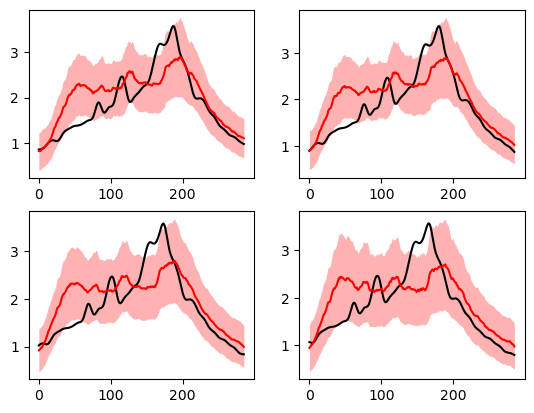

KeyError: 2016

In [13]:
for test_season in [2015,2016,2017,2018]:
    pred = predictions[test_season]
    for num, g in zip([1,2,3,4], [6,13,20,27]):
        plt.subplot(2,2,num)
        plt.plot(pred['true'][:, g, -1], color='black')
        plt.plot(pred['mean'][:, g, -1], color='red')
        plt.fill_between(np.arange(pred['true'].shape[0]), (pred['mean']-pred['std'])[:, g, -1], (pred['mean']+pred['std'])[:, g, -1], color='red', linewidth = 0, alpha = 0.3)
    plt.show()